# Аспектный анализ тональности текстов

Рассмотрим задачу анализа тональности текстов на примерах отзывов об автомобилях, и для этого мы будем использовать датасет, который предлагался участникам соревнования SentiRuEval-2015

* [1] https://github.com/nlpub/pymystem3
* [2] SentiRuEval2015
* [3] https://rusvectores.org/ru/models/

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

QUICK_RUN = True

In [3]:
# на темном фоне выбранная в пакете dlnlputils палитра нечитаемая, подкрутим
from ipymarkup.palette import material, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

colors = BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

for c in colors:
    color_name = c.name[0].capitalize() + c.name[1:]
    c.background = material(color_name, '900')

## Оригинальная разметка

У нас есть оригинальный XML-файл с размеченными отзывами об автомобилях, поделённый на training-часть и test-часть, по 200 отзывов в каждом. 

Содержимое этих файлов выглядит следующим образом: 
- в отзыве присутствует разметка, в которой выделены ключевые слова в тексте, означающие 
  - позитивную, 
  - нейтральную
  - негативную оценку. 

Например, "просторный багажник" — это пример позитивной оценки в отзыве об автомобиле. А такие слова, как "руль закрывает обзор" — это явно негативная часть отзыва. 

In [4]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_sentiments = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'

In [5]:
from dlnlputils.sentiment_utils import parse_xml_sentiment, parse_xml_aspect, show_markup

тексты с разметкой аспектов и тональностей: 

In [6]:
texts_w_sentiment_spans = parse_xml_sentiment(xml_sentiments)
texts_w_aspect_spans    = parse_xml_aspect(xml_sentiments)

In [7]:
amount = len(texts_w_sentiment_spans)

print('Загружено {} текстов с разметкой тональности\n'.format(amount))

Загружено 217 текстов с разметкой тональности



##### выберем 2 текста, на которых будем рассматривать все примеры:

In [8]:
random_picks = [random.randint(0,amount-1) for _ in range(0,2)]

####  тональность (sentiment)

In [9]:
for rand_i in random_picks:
    text, spans = texts_w_sentiment_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 170


Текст №: 45


####  Аспекты (aspects)

Также, помимо тональности, у нас есть аспекты — категории, которые упомянуты в отзыве. Проще говоря, в отзывах есть некие аспекты или категории, о которых написан отзыв, например — "общее впечатление" об автомобиле, "надёжность", "стоимость", "управляемость", "внешний вид", "комфорт"...

In [10]:
for rand_i in random_picks:
    text,spans = texts_w_aspect_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 170


Текст №: 45


## BIO-тэги для обучения модели

На основе оригинальной разметки к данному датасету мы подготовили BIO-разметку, чтобы размеченный таким образом датасет можно было подавать на вход нашей нейросети. 

Как можно видеть, мы добавили тэг "OTHER" для всех слов, которые не относятся к аспектам или тональности, объединили в сущности, стоящие рядом. 

[1] http://www.dialog-21.ru/evaluation/2015/sentiment/

In [11]:
from dlnlputils.sentiment_utils import fill_gaps, extract_BIO_tagged_tokens

In [12]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]
    cover_spans       = fill_gaps(text, aspect_spans)
    
    print('Полное покрытие разметкой текста №:',rand_i) 
    show_markup(text, cover_spans)

Полное покрытие разметкой текста №: 170


Полное покрытие разметкой текста №: 45


Дальнейшая задача заключается в том, чтобы построить алгоритм, который сможет автоматически определять аспекты, о которых оставлен отзыв — например, управляемость автомобиля, комфорт, стоимость, внешний вид, и так далее

### Разбиение текста на предложения, а предложений - на слова.

In [13]:
from dlnlputils.sentiment_utils import regex_sentence_detector, sentence_spans,sentence_splitter

In [14]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [15]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]

    print('Разбиение на предложения и BIO токенизация текста №:',rand_i) 
    for sentence, spans in sentence_splitter(text, aspect_spans):

        cover_spans      = fill_gaps(sentence,spans)
        tokens_w_biotags = extract_BIO_tagged_tokens(sentence, 
                                                     cover_spans, 
                                                     word_tokenizer.tokenize)

        show_markup(sentence, cover_spans)
        print(tokens_w_biotags[:10],'\n')

Разбиение на предложения и BIO токенизация текста №: 170


[('Отличный', 'Other'), ('автомобиль', 'B-Whole'), ('для', 'Other'), ('любителей', 'Other'), ('(а', 'Other'), ('их', 'Other'), ('много', 'Other'), (')', 'Other'), ('настоящих', 'Other'), ('японцев', 'Other')] 



[('Машина', 'B-Whole'), ('экономичная', 'B-Costs'), (',', 'Other'), ('красивая', 'B-Appearance'), (',', 'Other'), ('престижная', 'Other'), ('.', 'Other')] 



[('Не', 'B-Costs'), ('дорого', 'I-Costs'), ('её', 'Other'), ('обслуживать', 'B-Costs'), (',', 'Other'), ('дешевые', 'B-Costs'), ('детали', 'B-Costs')] 



[('Хорошо', 'Other'), ('слушается', 'B-Driveability'), (',', 'Other'), ('особенно', 'Other'), ('в', 'Other'), ('мерзлую', 'Other'), ('или', 'Other'), ('дождливую', 'Other'), ('погоду', 'Other'), ('.', 'Other')] 



[('У', 'Other'), ('меня', 'Other'), ('все', 'Other'), ('машины', 'B-Whole'), ('фирмы', 'I-Whole'), ('тойота', 'I-Whole'), ('и', 'Other'), ('ни', 'Other'), ('разу', 'Other'), ('не', 'Other')] 



[('Как', 'Other'), ('праворульные', 'B-Driveability'), ('так', 'Other'), ('и', 'Other'), ('леворульные', 'B-Driveability'), (',', 'Other'), ('особенно', 'Other'), ('если', 'Other'), ('тех', 'Other'), ('90', 'Other')] 



[('Советую', 'Other'), ('брать', 'Other'), ('.', 'Other')] 



[('Более', 'Other'), ('того', 'Other'), (',', 'Other'), ('во', 'Other'), ('всех', 'Other'), ('тойотах', 'B-Comfort'), ('отличный', 'Other'), ('климат', 'B-Comfort'), ('контроль', 'I-Comfort')] 



[('Общее', 'Other'), ('впечатление', 'Other'), (':', 'Other'), ('Хорошая', 'Other'), ('рабочая', 'B-Whole'), ('лошадка', 'I-Whole')] 

Разбиение на предложения и BIO токенизация текста №: 45


[('Не', 'Other'), ('давно', 'Other'), ('приобрел', 'Other'), ('этот', 'Other'), ('авто', 'B-Whole'), ('выбор', 'Other'), ('был', 'Other'), ('между', 'Other'), ('Ваз', 'B-Whole'), ('и', 'Other')] 



[('За', 'Other'), ('период', 'Other'), ('эксплуатации', 'Other'), ('не', 'Other'), ('раз', 'Other'), ('не', 'Other'), ('подводила', 'Other'), ('конечно', 'Other'), ('это', 'Other'), ('не', 'Other')] 



[('Машина', 'B-Whole'), ('для', 'Other'), ('девушек', 'Other'), ('самый', 'Other'), ('раз', 'Other'), ('маневрировать', 'B-Driveability'), ('в', 'I-Driveability'), ('пробках', 'I-Driveability'), ('очень', 'Other'), ('удобно', 'B-Comfort')] 



[('Не', 'Other'), ('смотря', 'Other'), ('на', 'Other'), ('маленькие', 'B-Appearance'), ('габариты', 'I-Appearance'), ('машинка', 'B-Comfort'), ('довольно', 'Other'), ('просторная', 'B-Comfort')] 



[('В', 'B-Costs'), ('обслуживании', 'I-Costs'), ('обходится', 'Other'), ('очень', 'Other'), ('дешево', 'B-Costs'), (',', 'Other'), ('запчасти', 'B-Costs'), ('на', 'Other'), ('каждом', 'Other'), ('углу', 'Other')] 



[('Самое', 'Other'), ('главное', 'Other'), ('автомобиль', 'B-Costs'), ('сам', 'Other'), ('не', 'B-Costs'), ('дорогой', 'I-Costs'), (')))', 'Other')] 



##  Подготовка данных для обучения: 

Загрузим тренировочные и тестовые данные.

In [16]:
from dlnlputils.sentiment_utils import prepare_data, form_vocabulary_and_tagset

In [17]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_train = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
xml_test  = 'datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'

### Токенизация: 

Составим словарь всех слов и всех тэгов, которые встречаются в нашем датасете.

In [18]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)


#### разбиение на предложения дало нам столько коротких текстов:

In [19]:
len(training_data), len(test_data)

(2210, 1922)

In [20]:
all_data = training_data + test_data

In [21]:
vocabulary, labels = form_vocabulary_and_tagset(all_data)

In [22]:
labels

{'B-Appearance',
 'B-Comfort',
 'B-Costs',
 'B-Driveability',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'I-Appearance',
 'I-Comfort',
 'I-Costs',
 'I-Driveability',
 'I-Reliability',
 'I-Safety',
 'I-Whole',
 'Other'}

#### а размер словаря:

In [23]:
len(vocabulary), len(labels)

(11333, 15)

#### индексация:

- применим уже знакомый вам по прошлому семинару конвертер для индексации

In [24]:
from dlnlputils.sentiment_utils import Converter, generate_markup

In [25]:
converter = Converter(vocabulary,labels)

In [26]:
test_recipe, test_tags = training_data[1211]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()

decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(decoded_recipe, decoded_tags) 

show_markup(text, spans)

tensor([ 1395,  7307, 10381,  3591,  6303,  2877,  6524,  6847,  7826,   289,
         8063,  9912,  8648,  5768,  6381,   823,  7653,  6064,  7835,   289,
         5435,  3739,  2737,  9234,   289,  5331,   289,  2540,   289,  9247])
tensor([14, 14, 14, 14, 14, 14,  4, 11, 11, 14, 14, 14, 14, 14,  4, 14,  4, 11,
        11, 14,  4, 11, 11, 11, 14,  4, 14,  4, 14,  4])



### Нейросети

In [27]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

###  Предобученные векторы слов

Алгоритм fastText обученный на корпусе Тайга, смотрите подробности на сайте: https://rusvectores.org/ru/models/
- 2.5 Gb


In [28]:
# !pip3 install wget

In [29]:
import gensim
# import wget
# import zipfile

model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
# wget.download(model_url)
# with zipfile.ZipFile('187.zip', 'r') as zip_ref:
#     zip_ref.extractall('datasets/187/')
model_file = 'datasets/' + model_url.split('/')[-1]

В предобученной модели FastText, наверное, присутствуют следующие слова: "тачка", "двигатель" и "Audi".
-  какие векторы являются ближайшими к векторам этих слов

In [30]:
w2v_model = gensim.models.KeyedVectors.load('datasets/187/model.model') #  (30 сек)

In [31]:
words = ['тачка', 'двигатель', 'ауди']

for word in words:
    if word in w2v_model:
           
        for i in w2v_model.most_similar(positive=[word], topn=10):
            nearest_word      = i[0]
            cosine_similarity = i[1]
            print(nearest_word, cosine_similarity)
        print('\n')
    
    else: 
        print(word + ' is not present in the model')

жигулёнка 0.7488206028938293
ишачка 0.7310285568237305
грузовичка 0.7278669476509094
жигулёнок 0.7127147912979126
жигуленок 0.7064321041107178
тележка 0.6995413899421692
мопед 0.6990944147109985
сачка 0.6923120617866516
катафалка 0.6904969215393066
бричка 0.6855131387710571


двигатели 0.9118231534957886
гипердвигатель 0.8655393123626709
электродвигатель 0.8446590304374695
мотор 0.8106048107147217
электромотор 0.8067885637283325
авиадвигатель 0.7910488843917847
движок 0.7793391346931458
перводвигатель 0.7768319845199585
двигательный 0.7394744157791138
турбина 0.7326768040657043


bmw 0.7961360216140747
бмв 0.7914925813674927
аудь 0.7911134958267212
тойота 0.7723557949066162
мерседес 0.7654416561126709
mw 0.7585864067077637
bmv 0.7522682547569275
форд 0.7281615734100342
тойот 0.7268385887145996
лексус 0.7258473634719849




Предобученные векторы из модели FastText мы будем использовать в качестве основы для обучения нашей нейросети LSTM. Из всего множества векторов FastText мы возьмём только 11 333 вектора, соответствующие всем словам в нашем датасете, и поместим их в embedding матрицу.

In [32]:
numpy_embeddings = np.zeros(shape=[VOCAB_SIZE, EMBEDDING_DIM],dtype=np.float32)

for word in vocabulary:
    if word in w2v_model:
        vector = w2v_model.get_vector(word)
        index  = converter.words_to_index([word])
        numpy_embeddings[index] = vector
        
    else: print(word + ' - такого слова нет в модели fasttext')
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([11333, 300])

### LSTM 

1. Использует предобученные вектора слов и не изменяет их (`freeze=True`):
- `nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)`
- это позволит нейросети сконцентрироваться на обучении собственных компонент

\*) Модель с предобученными эмбеддинграми токенов:
- Она предпочтительна в случае, когда у нас мало обучающих данных.
- Есть шанс, что модель сможет правильно классифицировать слова, синонимы которых она видела при обучении.
- Она сохранит взаимное расположение векторов слов исходной языковой модели.
1. Двунаправленная
- слова попадают в объект "конвертер" и для них происходит замена индекса
- в матрице эмбеддингов алгоритм находит векторы этих слов
- они, в свою очередь, попадают в LSTM. Но теперь это двунаправленная модель, и она также будет двигаться по предложению в обратном направлении
- по сути это две параллельно работающие LSTM с идентичными параметрами, одной из которых на вход подается реверсированная последовательность
  - соответственно для каждого входного вектора она предсказывает пару классов (для прямой и обратной подачи последовательности)
  - из эти двух предсказанных меток все равно будет выбрана одна с наибольшей метрикой (в данном случае софтмакса)
    - для этого размерность входа последнего слоя сети (линейный полносвязный слой, который выдает значения признаков, которые считаем логитами) указана в **удвоенном объеме**

In [33]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pretrained_embeddings):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag      = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

### Взвешеная функция потерь

Модификация, которая позволит нам добиться более высоких результатов — это взвешенная функция потерь (позволит снизить влияние дисбаланса классов на метрики (функцию потерь)). 

Из приведённой статистики мы видим, что тэг "other" встречается довольно часто (я бы сказал, почти всегда), а тэг "внешний вид" и тэг "безопасность" встречаются довольно редко. Мы хотим, чтобы взвешенная функция потерь сильнее штрафовала нашу нейросеть за ошибки при предсказании этих редких тэгов. Мы снова запустим процесс обучения прямо в браузере и вы сможете увидеть, как уменьшается функция потерь от эпохи к эпохе. Будем обучаться в течение семи эпох.

In [34]:
from collections import Counter

tag_counter = Counter()
for _,tokens in training_data:
    for token in tokens:
        tag_counter[token]+=1
        
tag_counter.most_common()     

[('Other', 23529),
 ('B-Driveability', 1188),
 ('B-Comfort', 1092),
 ('I-Driveability', 773),
 ('B-Reliability', 769),
 ('B-Whole', 768),
 ('I-Comfort', 480),
 ('I-Reliability', 457),
 ('B-Costs', 392),
 ('B-Appearance', 354),
 ('I-Whole', 310),
 ('I-Costs', 177),
 ('I-Appearance', 146),
 ('B-Safety', 87),
 ('I-Safety', 63)]

In [35]:
class_weights = torch.ones(15)
class_divs    = torch.ones(15)

for tag, inv_weight in tag_counter.most_common():
    tag_idx             = converter.tags_to_index([tag])
    class_divs[tag_idx] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))


class_weights /= class_divs


print(class_weights.detach())

tensor([ 66.7812,  21.6488,  60.3075,  19.8994,  30.7419, 271.7303,  30.7819,
        161.9215,  49.2511, 133.5623,  30.5828,  51.7298, 375.2466,  76.2598,
          1.0047])


In [36]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE, pretrained_embeddings)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

#### training
10 эпох 5 минут на хосте

In [37]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

if not QUICK_RUN:    
    for epoch in range(10): 
        for i, (recipe, tags) in enumerate(training_data):
            
            model.zero_grad()
            
            encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
            encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
            tag_scores     = model(encoded_recipe)
            
            loss = loss_function(tag_scores, encoded_tags)
            loss.backward()
            optimizer.step()
            
            
            if i % 100 == 0:
                liveplot.update({'negative log likelihood loss': loss.detach().numpy()})
                liveplot.draw()
            

In [38]:
if QUICK_RUN:
    model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE, pretrained_embeddings)
    model.load_state_dict(torch.load('models/aspect_sentiment.pt'))
else:
    torch.save(model.state_dict(), 'models/aspect_sentiment.pt')

In [39]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре

    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

Ошибок хватает

In [40]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,1000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    text, spans = generate_markup(recipe, tags) 
    show_markup(text, spans)

    print('предсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred) 

    show_markup(text, spans)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


### Статистика

##### 1.  Количество верно предсказанных тэгов:

In [41]:
from dlnlputils.sentiment_utils import tag_statistics

In [42]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для Other:
  корректно:	 17319
      всего:	 19922
% корректно:	 86.93404276679048

для B-Whole:
  корректно:	 501
      всего:	 673
% корректно:	 74.44279346210996

для B-Driveability:
  корректно:	 504
      всего:	 1066
% корректно:	 47.27954971857411

для I-Driveability:
  корректно:	 282
      всего:	 711
% корректно:	 39.66244725738397

для B-Appearance:
  корректно:	 170
      всего:	 275
% корректно:	 61.81818181818181

для I-Appearance:
  корректно:	 40
      всего:	 100
% корректно:	 40.0

для B-Reliability:
  корректно:	 367
      всего:	 809
% корректно:	 45.364647713226205

для I-Whole:
  корректно:	 89
      всего:	 213
% корректно:	 41.78403755868544

для B-Comfort:
  корректно:	 646
      всего:	 1067
% корректно:	 60.543580131209

для I-Comfort:
  корректно:	 185
      всего:	 497
% корректно:	 37.223340040241446

для I-Reliability:
  корректно:	 140
      всего:	 475
% корректно:	 29.47368421052631

для B-Costs:
  корректно:	 223

##### 2.  Количество верно предсказанных тэгов в виде матрицы ошибок:

Матрица ошибок, полученная на тестовом датасете, выглядит не так хорошо, как на датасете, на котором мы обучались. Это может быть связано с тем, что, например, в целом, наши датасеты довольно небольшие — это 200 текстов, в каждом по 2000 предложений и, возможно, нам нужно было ещё немного модифицировать функцию потерь, чтобы не так агрессивно взвешивать тэги. Более того, наша нейросеть могла просто переобучиться. 

In [43]:
from dlnlputils.sentiment_utils import plot_confusion_matrix

In [44]:
y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(model, converter, sentence)
    y_true += tags

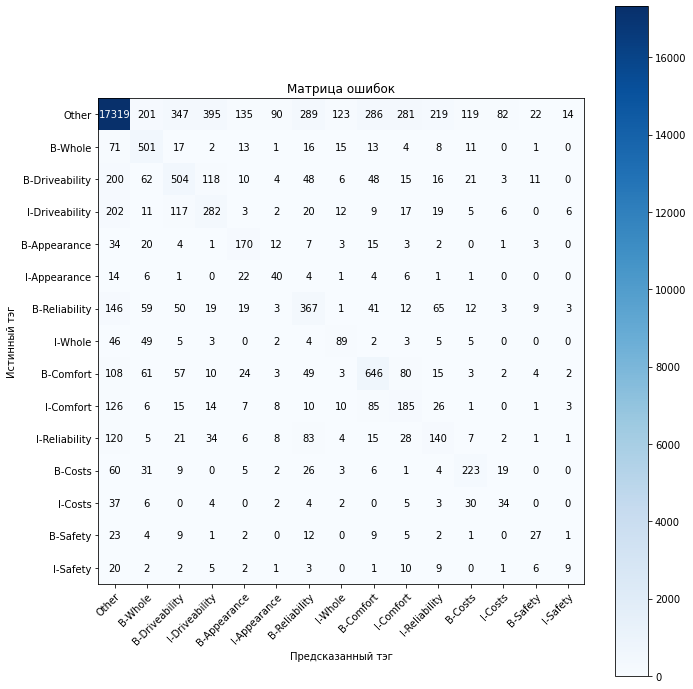

In [45]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

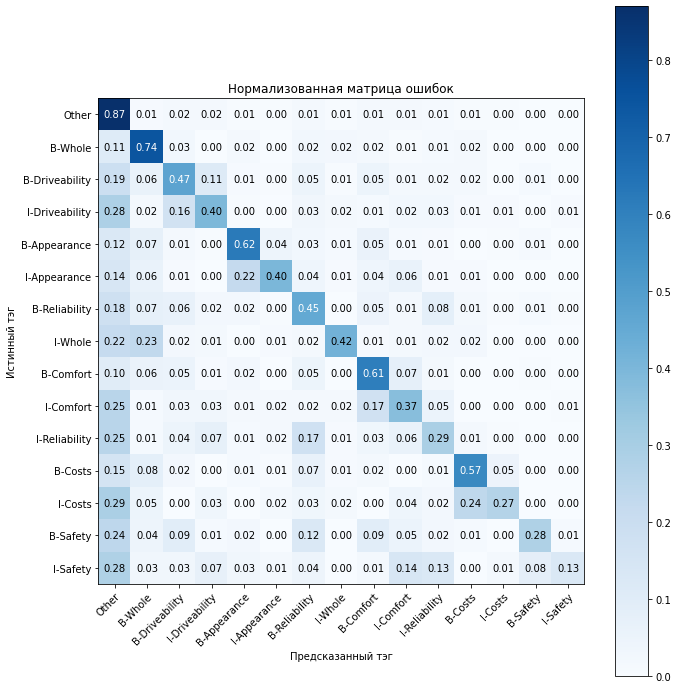

In [46]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()

PS: Мы поместили в embedding слой из модели fasttext векторы всех слов, которые входят в train и test выборки, но не подумали о том, как мы будем обрабатывать незнакомые слова. Если такая необходимость есть, то варианты примерно такие:

- Помимо замороженного embedding слоя сделать тренируемый embedding слой, состоящий из вектора `<unknown>`

- Положиться на возможности fastText: убрать из модели embedding слой и сделать отдельный конвертер: слово -> вектор fastText.

- Для незнакомых слов добавить тэг `<unknown>` и задать для него случайный вектор в embedding слое; Сделать embedding слой обучаемым.

Пример: `./stepik-dl-nlp/task7.1_aspect_sentiment_eval.ipynb`